In [ ]:
pip install tensorflow-cpu==2.12.0


In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Device:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")


TensorFlow version: 2.12.0
Device: CPU


In [2]:
# Sentiment Analysis — 4 separate models
# Run in Colab or local env. Ensure packages installed:
# pip install pandas numpy matplotlib scikit-learn xgboost tensorflow nltk wordcloud

import re
import os
import numpy as np
import pandas as pd
np.random.seed(0)

# plotting
import matplotlib.pyplot as plt

# text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# keras for CNN
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# utilities
import joblib
from collections import Counter


In [3]:
#Settings & Download NLTK resources (first-run)

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chait\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chait\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chait\AppData\Roaming\nltk_data...


True

In [7]:
# Load data

train_path = "C:/Users/chait/Downloads/twitter_training.csv"  #"data/twitter_training.csv"
valid_path = "C:/Users/chait/Downloads/twitter_validation.csv"  # "data/twitter_validation.csv"  


In [8]:
# If your CSVs have headers already, remove the names=... part. The user's snippet used names=...
train_df = pd.read_csv(train_path, names=["Tweet_ID", "Entity", "Sentiment", "Tweet_Content"], header=None)
valid_df = pd.read_csv(valid_path, names=["Tweet_ID", "Entity", "Sentiment", "Tweet_Content"], header=None)

In [51]:
train_df.head()

,Tweet_ID,Entity,Sentiment,Tweet_Content,clean_text,Sentiment_Label,tweet_length,Sentiment_Code,Tweet_Length
0,2535,Borderlands,2,@ Borderlands. Can we get a big fix please? I'...,borderland get big fix please reset entire fac...,Negative,30,2,30
1,11073,TomClancysGhostRecon,2,@GhostRecon You call 1.1.0 an update. You're h...,call update laugh stay connected min without s...,Negative,44,2,44
2,3024,Dota2,0,I'm excited to watch the EU's closed qualifyin...,excited watch eu closed qualifying match valve...,Neutral,20,0,20
3,6719,Fortnite,2,"anyways but my fortnite here,, im annoyed.",anyways fortnite im annoyed,Negative,7,2,7
4,1533,Battlefield,2,Collateral with the revolver is so satisfying....,collateral revolver satisfying unk youtu quo r...,Negative,10,2,10


In [9]:
# basic cleanup
train_df = train_df.dropna().reset_index(drop=True)
valid_df = valid_df.dropna().reset_index(drop=True)

In [27]:
train_df.shape

(14799, 7)

In [39]:
#See overall information about the data frame
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14799 entries, 0 to 14798
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Tweet_ID         14799 non-null  int64 
 1   Entity           14799 non-null  object
 2   Sentiment        14799 non-null  int32 
 3   Tweet_Content    14799 non-null  object
 4   clean_text       14799 non-null  object
 5   Sentiment_Label  14799 non-null  object
 6   tweet_length     14799 non-null  int64 
 7   Sentiment_Code   14799 non-null  int8  
 8   Tweet_Length     14799 non-null  int64 
dtypes: int32(1), int64(3), int8(1), object(4)
memory usage: 881.7+ KB


In [40]:
train_df.head()

,Tweet_ID,Entity,Sentiment,Tweet_Content,clean_text,Sentiment_Label,tweet_length,Sentiment_Code,Tweet_Length
0,2535,Borderlands,2,@ Borderlands. Can we get a big fix please? I'...,borderland get big fix please reset entire fac...,Negative,30,2,30
1,11073,TomClancysGhostRecon,2,@GhostRecon You call 1.1.0 an update. You're h...,call update laugh stay connected min without s...,Negative,44,2,44
2,3024,Dota2,0,I'm excited to watch the EU's closed qualifyin...,excited watch eu closed qualifying match valve...,Neutral,20,0,20
3,6719,Fortnite,2,"anyways but my fortnite here,, im annoyed.",anyways fortnite im annoyed,Negative,7,2,7
4,1533,Battlefield,2,Collateral with the revolver is so satisfying....,collateral revolver satisfying unk youtu quo r...,Negative,10,2,10


<BarContainer object of 4 artists>

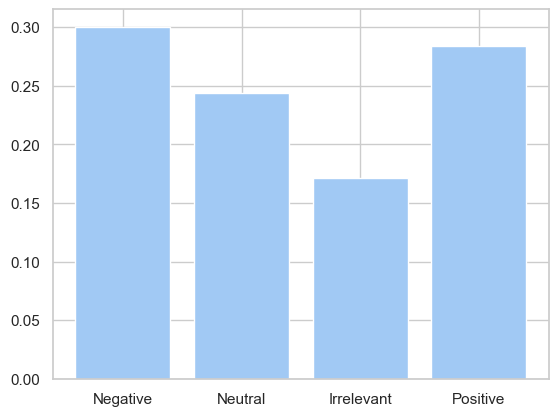

In [49]:
#Checking balance of target classes
sentiments = list(train_df["Sentiment_Label"].unique())

sentiment_nums = [len(train_df[train_df["Sentiment_Label"] == sentiment]) / len(train_df) for sentiment in sentiments]

plt.bar(sentiments, sentiment_nums)

In [10]:
# optional quick-sample (useful for fast experiments; set to 1.0 to use full data)
SAMPLE_FRAC = 1.0   # change to 0.1 if you want a quick run like earlier
train_df = train_df.sample(frac=SAMPLE_FRAC, random_state=0).reset_index(drop=True)

print("Train samples:", len(train_df), "Validation samples:", len(valid_df))

Train samples: 14799 Validation samples: 1000


In [11]:
# Label encoding (consistent mapping)

class_to_index = {"Neutral":0, "Irrelevant":1, "Negative":2, "Positive": 3}
index_to_class = {v:k for k,v in class_to_index.items()}

# If dataset uses exactly those labels; if not, adjust mapping accordingly
train_df['Sentiment'] = train_df['Sentiment'].map(class_to_index)
valid_df['Sentiment'] = valid_df['Sentiment'].map(class_to_index)

# If mapping produced NaNs (unknown labels), drop them:
train_df = train_df.dropna(subset=['Sentiment']).reset_index(drop=True)
valid_df = valid_df.dropna(subset=['Sentiment']).reset_index(drop=True)
train_df['Sentiment'] = train_df['Sentiment'].astype(int)
valid_df['Sentiment'] = valid_df['Sentiment'].astype(int)

In [12]:
# Preprocessing function

lemmatizer = WordNetLemmatizer()
stop_english = set(stopwords.words('english'))

def clean_text(text):
    if pd.isna(text):
        return ""
    txt = str(text)
    txt = txt.lower()
    # remove urls, mentions, hashtags (but keep hashtag text)
    txt = re.sub(r'http\S+', '', txt)
    txt = re.sub(r'@\w+', '', txt)
    txt = re.sub(r'#', '', txt)
    # remove non-alpha characters (keep spaces)
    txt = re.sub(r'[^a-z\s]', ' ', txt)
    # tokenize
    tokens = word_tokenize(txt)
    # lemmatize & remove stopwords & short tokens
    tokens = [lemmatizer.lemmatize(t) for t in tokens if (t not in stop_english) and len(t) > 1]
    return " ".join(tokens)

In [13]:
# Create cleaned text columns
train_df['clean_text'] = train_df['Tweet_Content'].apply(clean_text)
valid_df['clean_text'] = valid_df['Tweet_Content'].apply(clean_text)

In [14]:
# quick look
print(train_df[['Tweet_Content','clean_text']].head())

                                       Tweet_Content  \
0  @ Borderlands. Can we get a big fix please? I'...   
1  @GhostRecon You call 1.1.0 an update. You're h...   
2  I'm excited to watch the EU's closed qualifyin...   
3         anyways but my fortnite here,, im annoyed.   
4  Collateral with the revolver is so satisfying....   

                                          clean_text  
0  borderland get big fix please reset entire fac...  
1  call update laugh stay connected min without s...  
2  excited watch eu closed qualifying match valve...  
3                        anyways fortnite im annoyed  
4  collateral revolver satisfying unk youtu quo r...  


In [15]:
#  Train/Val split for experiments (we'll use train_df for training, valid_df for final eval)
X_train_text = train_df['clean_text'].values
y_train = train_df['Sentiment'].values

X_valid_text = valid_df['clean_text'].values
y_valid = valid_df['Sentiment'].values

# For local model comparisons we may also create an internal holdout:
X_tr, X_te, y_tr, y_te = train_test_split(X_train_text, y_train, test_size=0.2, stratify=y_train, random_state=0)

In [16]:
# Helper: Plot confusion matrix
import seaborn as sns

def plot_cm(y_true, y_pred, labels_map=index_to_class, model_name="", accuracy=None):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm, annot=True, fmt=".2f", cmap="viridis",
        xticklabels=[labels_map[i] for i in labels_map],
        yticklabels=[labels_map[i] for i in labels_map]
    )
    title_text = f"{model_name} (accuracy:{accuracy*100:.0f}%)" if accuracy else model_name
    plt.title(title_text, fontsize=14, weight='bold', color='#333', pad=12)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()



=== MODEL A: Logistic Regression (TF-IDF) ===
Internal holdout accuracy: 0.6574324324324324
              precision    recall  f1-score   support

     Neutral       0.61      0.67      0.64       721
  Irrelevant       0.54      0.57      0.56       508
    Negative       0.71      0.70      0.71       889
    Positive       0.72      0.65      0.68       842

    accuracy                           0.66      2960
   macro avg       0.65      0.65      0.65      2960
weighted avg       0.66      0.66      0.66      2960



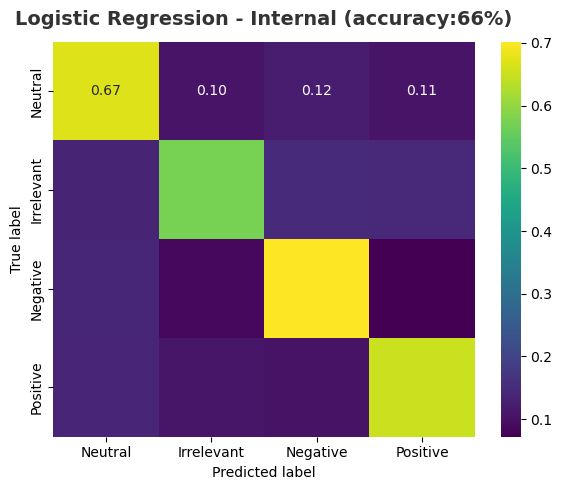

Validation accuracy (LR): 0.691


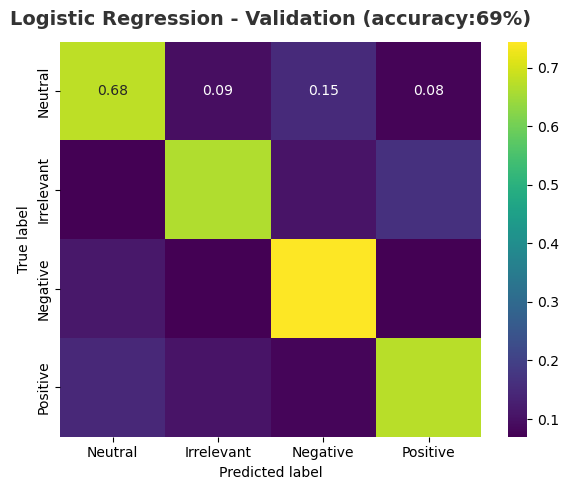

['tfidf_vectorizer.joblib']

In [17]:

# MODEL A: Logistic Regression (TF-IDF)

print("\n=== MODEL A: Logistic Regression (TF-IDF) ===")

tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
tfidf.fit(X_train_text)

X_tr_tfidf = tfidf.transform(X_tr)
X_te_tfidf = tfidf.transform(X_te)
X_valid_tfidf = tfidf.transform(X_valid_text)

lr = LogisticRegression(max_iter=200, random_state=0, class_weight='balanced')
lr.fit(X_tr_tfidf, y_tr)

# Internal holdout
y_pred_te = lr.predict(X_te_tfidf)
acc_te_lr = accuracy_score(y_te, y_pred_te)
print("Internal holdout accuracy:", acc_te_lr)
print(classification_report(y_te, y_pred_te, target_names=[index_to_class[i] for i in sorted(index_to_class.keys())]))
plot_cm(y_te, y_pred_te, index_to_class, model_name="Logistic Regression - Internal", accuracy=acc_te_lr)

# External validation
y_pred_valid_lr = lr.predict(X_valid_tfidf)
acc_lr = accuracy_score(y_valid, y_pred_valid_lr)
print("Validation accuracy (LR):", acc_lr)
plot_cm(y_valid, y_pred_valid_lr, index_to_class, model_name="Logistic Regression - Validation", accuracy=acc_lr)

joblib.dump(lr, "model_logistic.joblib")
joblib.dump(tfidf, "tfidf_vectorizer.joblib")



=== MODEL B: Random Forest (TF-IDF) ===
Internal holdout accuracy: 0.7067567567567568
              precision    recall  f1-score   support

     Neutral       0.68      0.70      0.69       721
  Irrelevant       0.78      0.49      0.60       508
    Negative       0.70      0.81      0.75       889
    Positive       0.72      0.74      0.73       842

    accuracy                           0.71      2960
   macro avg       0.72      0.68      0.69      2960
weighted avg       0.71      0.71      0.70      2960



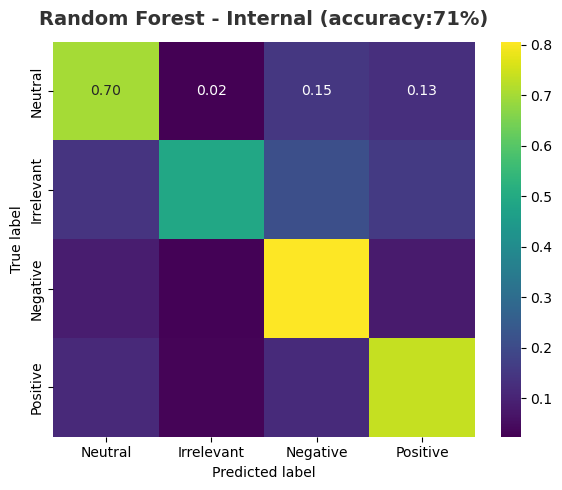

Validation accuracy (RF): 0.744


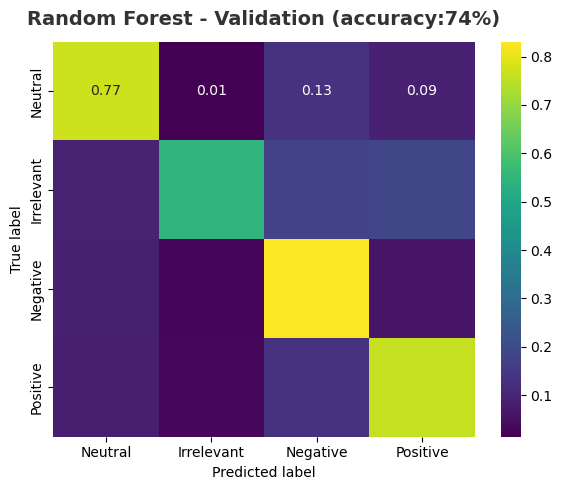

['model_random_forest.joblib']

In [18]:

# MODEL B: Random Forest (TF-IDF)

print("\n=== MODEL B: Random Forest (TF-IDF) ===")

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=0,
    n_jobs=-1,
    class_weight='balanced'
)
rf.fit(X_tr_tfidf, y_tr)

# Internal holdout
y_pred_te_rf = rf.predict(X_te_tfidf)
acc_te_rf = accuracy_score(y_te, y_pred_te_rf)
print("Internal holdout accuracy:", acc_te_rf)
print(classification_report(y_te, y_pred_te_rf, target_names=[index_to_class[i] for i in sorted(index_to_class.keys())]))
plot_cm(y_te, y_pred_te_rf, index_to_class, model_name="Random Forest - Internal", accuracy=acc_te_rf)

# External validation
y_pred_valid_rf = rf.predict(X_valid_tfidf)
acc_rf = accuracy_score(y_valid, y_pred_valid_rf)
print("Validation accuracy (RF):", acc_rf)
plot_cm(y_valid, y_pred_valid_rf, index_to_class, model_name="Random Forest - Validation", accuracy=acc_rf)

joblib.dump(rf, "model_random_forest.joblib")



=== MODEL C: XGBoost (TF-IDF) ===


C:\Users\chait\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:39:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Internal holdout accuracy: 0.5722972972972973
              precision    recall  f1-score   support

     Neutral       0.65      0.49      0.56       721
  Irrelevant       0.58      0.25      0.35       508
    Negative       0.51      0.82      0.62       889
    Positive       0.64      0.58      0.61       842

    accuracy                           0.57      2960
   macro avg       0.59      0.53      0.53      2960
weighted avg       0.59      0.57      0.56      2960



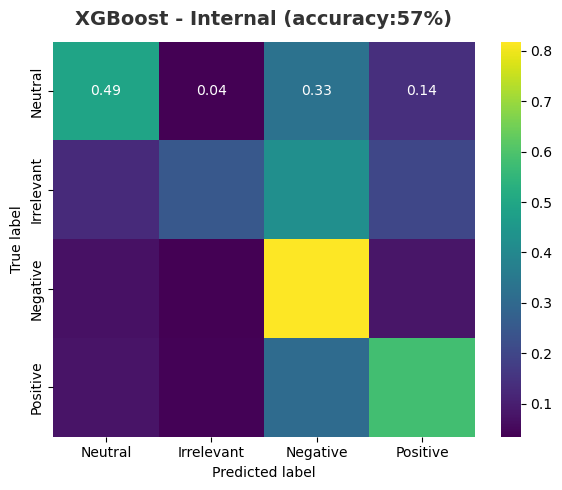

Validation accuracy (XGBoost): 0.615


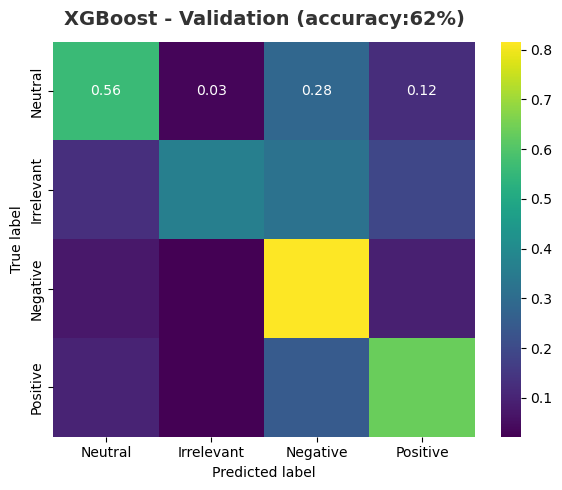

['model_xgboost.joblib']

In [19]:

# MODEL C: XGBoost (TF-IDF)

print("\n=== MODEL C: XGBoost (TF-IDF) ===")

xgb_clf = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(index_to_class),
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=200,
    learning_rate=0.1,
    random_state=0,
    n_jobs=-1
)
xgb_clf.fit(X_tr_tfidf, y_tr, eval_set=[(X_te_tfidf, y_te)], verbose=False)

# Internal holdout
y_pred_te_xgb = xgb_clf.predict(X_te_tfidf)
acc_te_xgb = accuracy_score(y_te, y_pred_te_xgb)
print("Internal holdout accuracy:", acc_te_xgb)
print(classification_report(y_te, y_pred_te_xgb, target_names=[index_to_class[i] for i in sorted(index_to_class.keys())]))
plot_cm(y_te, y_pred_te_xgb, index_to_class, model_name="XGBoost - Internal", accuracy=acc_te_xgb)

# External validation
y_pred_valid_xgb = xgb_clf.predict(X_valid_tfidf)
acc_xgb = accuracy_score(y_valid, y_pred_valid_xgb)
print("Validation accuracy (XGBoost):", acc_xgb)
plot_cm(y_valid, y_pred_valid_xgb, index_to_class, model_name="XGBoost - Validation", accuracy=acc_xgb)

joblib.dump(xgb_clf, "model_xgboost.joblib")



=== MODEL D: CNN (Keras Conv1D) ===
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           1000000   
                                                                 
 conv1d (Conv1D)             (None, 48, 128)           38528     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                   

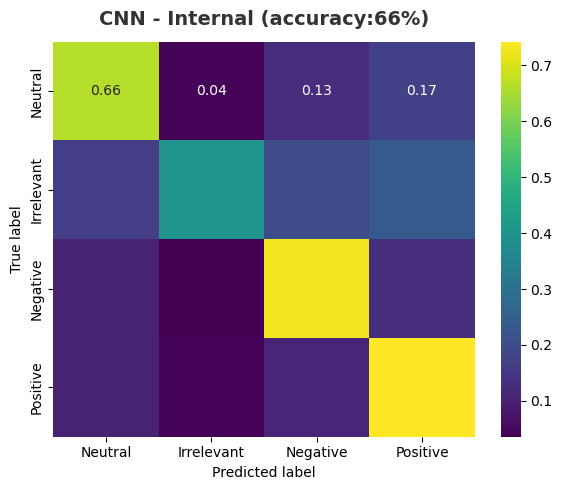

32/32 [==============================] - 0s 6ms/step
Validation accuracy (CNN): 0.717


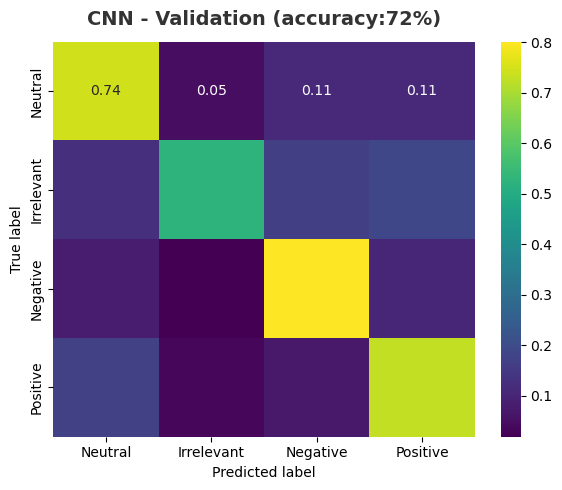

In [20]:

# MODEL D: CNN (Keras Conv1D)

print("\n=== MODEL D: CNN (Keras Conv1D) ===")

MAX_NUM_WORDS = 10000
MAX_SEQ_LEN = 50
EMBED_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, lower=True, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text)

X_tr_seq = tokenizer.texts_to_sequences(X_tr)
X_te_seq = tokenizer.texts_to_sequences(X_te)
X_valid_seq = tokenizer.texts_to_sequences(X_valid_text)

X_tr_pad = pad_sequences(X_tr_seq, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
X_te_pad = pad_sequences(X_te_seq, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
X_valid_pad = pad_sequences(X_valid_seq, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')

num_classes = len(index_to_class)
y_tr_cat = tf.keras.utils.to_categorical(y_tr, num_classes=num_classes)
y_te_cat = tf.keras.utils.to_categorical(y_te, num_classes=num_classes)
y_valid_cat = tf.keras.utils.to_categorical(y_valid, num_classes=num_classes)

cnn_model = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBED_DIM, input_length=MAX_SEQ_LEN),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()

es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

history = cnn_model.fit(
    X_tr_pad, y_tr_cat,
    validation_data=(X_te_pad, y_te_cat),
    epochs=12,
    batch_size=64,
    callbacks=[es],
    verbose=2
)

# Internal holdout
y_pred_prob = cnn_model.predict(X_te_pad)
y_pred_te_cnn = np.argmax(y_pred_prob, axis=1)
acc_te_cnn = accuracy_score(y_te, y_pred_te_cnn)
print("Internal holdout accuracy (CNN):", acc_te_cnn)
print(classification_report(y_te, y_pred_te_cnn, target_names=[index_to_class[i] for i in sorted(index_to_class.keys())]))
plot_cm(y_te, y_pred_te_cnn, index_to_class, model_name="CNN - Internal", accuracy=acc_te_cnn)

# External validation
y_pred_valid_prob = cnn_model.predict(X_valid_pad)
y_pred_valid_cnn = np.argmax(y_pred_valid_prob, axis=1)
acc_cnn = accuracy_score(y_valid, y_pred_valid_cnn)
print("Validation accuracy (CNN):", acc_cnn)
plot_cm(y_valid, y_pred_valid_cnn, index_to_class, model_name="CNN - Validation", accuracy=acc_cnn)

cnn_model.save("cnn_sentiment_model.h5")


In [21]:

# FINAL SUMMARY

print("\n=== SUMMARY (Validation set accuracies) ===")
print(f"Logistic Regression : {acc_lr:.3f}")
print(f"Random Forest       : {acc_rf:.3f}")
print(f"XGBoost             : {acc_xgb:.3f}")
print(f"CNN (Keras)         : {acc_cnn:.3f}")



=== SUMMARY (Validation set accuracies) ===
Logistic Regression : 0.691
Random Forest       : 0.744
XGBoost             : 0.615
CNN (Keras)         : 0.717


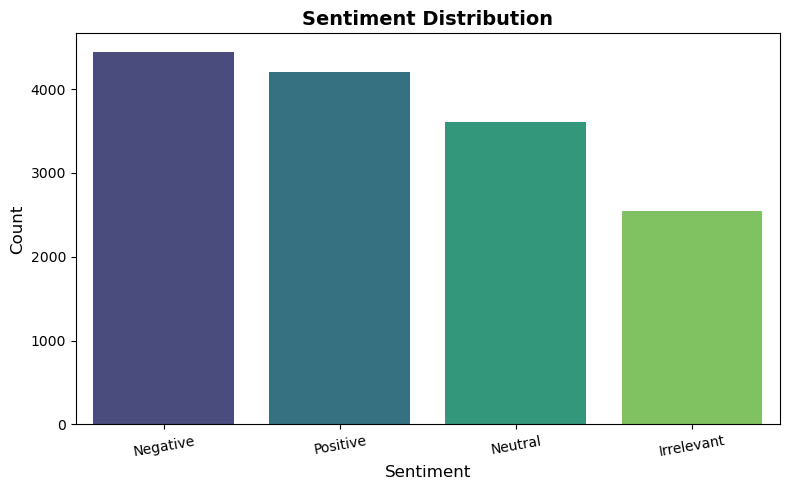

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named train_df and sentiment labels are numeric (0–3)
# Map them back to text labels for better visualization
sentiment_labels = {0: "Neutral", 1: "Irrelevant", 2: "Negative", 3: "Positive"}
train_df['Sentiment_Label'] = train_df['Sentiment'].map(sentiment_labels)

# Plot
plt.figure(figsize=(8, 5))
sns.countplot(
    data=train_df,
    x='Sentiment_Label',
    palette='viridis',
    order=['Negative', 'Positive', 'Neutral', 'Irrelevant']
)

plt.title("Sentiment Distribution", fontsize=14, weight='bold')
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=10)
plt.tight_layout()
plt.show()


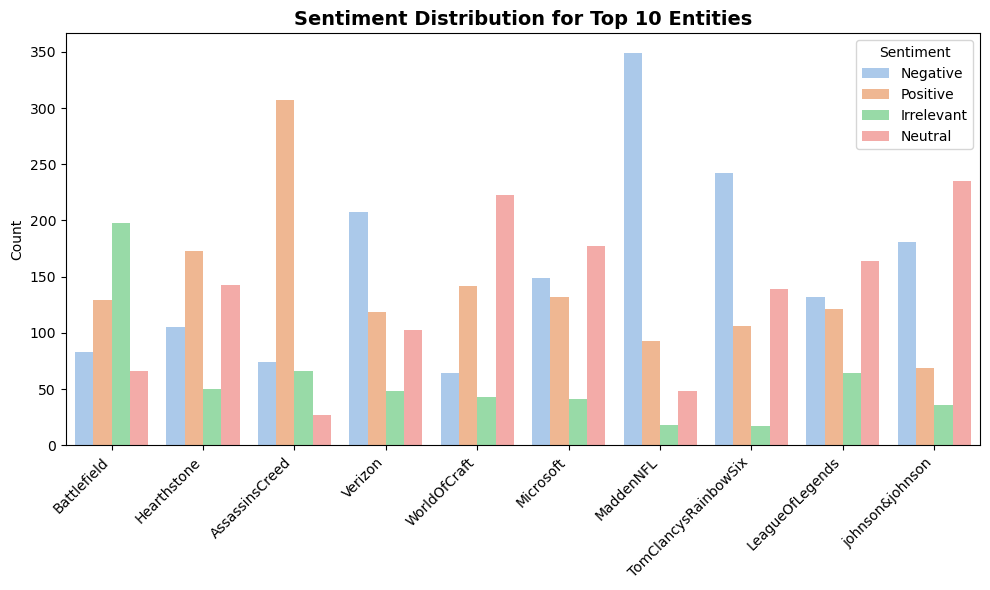

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Map numeric sentiment labels to text
sentiment_labels = {0: "Neutral", 1: "Irrelevant", 2: "Negative", 3: "Positive"}
train_df['Sentiment_Label'] = train_df['Sentiment'].map(sentiment_labels)

# Find top 10 most frequent entities
top_entities = train_df['Entity'].value_counts().nlargest(10).index

# Filter only those entities
top_entity_df = train_df[train_df['Entity'].isin(top_entities)]

# Plot countplot
plt.figure(figsize=(10, 6))
sns.countplot(
    data=top_entity_df,
    x='Entity',
    hue='Sentiment_Label',
    palette='pastel'
)

plt.title("Sentiment Distribution for Top 10 Entities", fontsize=14, weight='bold')
plt.xlabel("")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


In [25]:
print(train_df.columns)


Index(['Tweet_ID', 'Entity', 'Sentiment', 'Tweet_Content', 'clean_text',
       'Sentiment_Label'],
      dtype='object')


C:\Users\chait\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


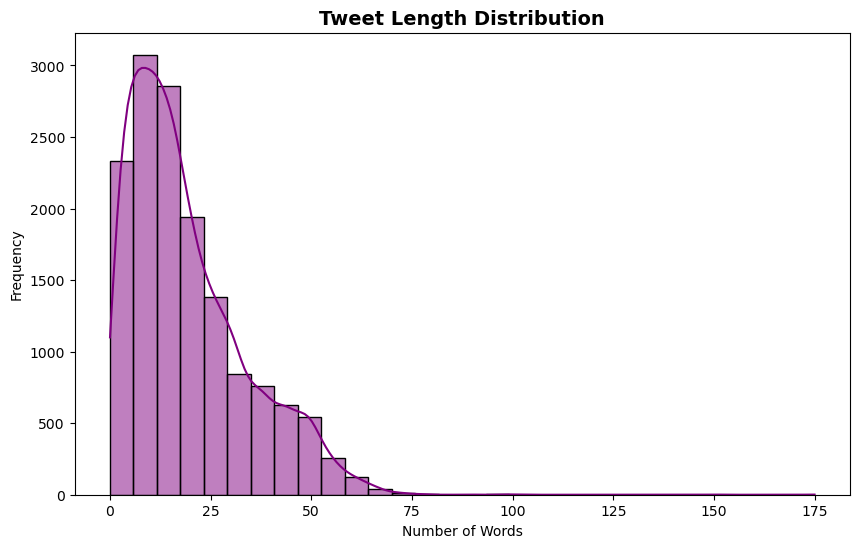

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate tweet lengths (number of words)
train_df['tweet_length'] = train_df['Tweet_Content'].apply(lambda x: len(str(x).split()))

# Plot the histogram with KDE
plt.figure(figsize=(10, 6))
sns.histplot(train_df['tweet_length'], bins=30, kde=True, color='purple')
plt.title('Tweet Length Distribution', fontsize=14, weight='bold')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()



In [29]:
pip install wordcloud


   ---------------------------------------- 0.0/299.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/299.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/299.9 kB ? eta -:--:--
   --- ----------------------------------- 30.7/299.9 kB 262.6 kB/s eta 0:00:02
   --- ----------------------------------- 30.7/299.9 kB 262.6 kB/s eta 0:00:02
   --- ----------------------------------- 30.7/299.9 kB 262.6 kB/s eta 0:00:02
   --- ----------------------------------- 30.7/299.9 kB 262.6 kB/s eta 0:00:02
   ---------- ---------------------------- 81.9/299.9 kB 255.1 kB/s eta 0:00:01
   ---------- ---------------------------- 81.9/299.9 kB 255.1 kB/s eta 0:00:01
   ---------- ---------------------------- 81.9/299.9 kB 255.1 kB/s eta 0:00:01
   ---------- ---------------------------- 81.9/299.9 kB 255.1 kB/s eta 0:00:01
   -------------- ----------------------- 112.6/299.9 kB 211.6 kB/s eta 0:00:01
   -------------- ----------------------- 112.6/299.9 kB 211.6 kB

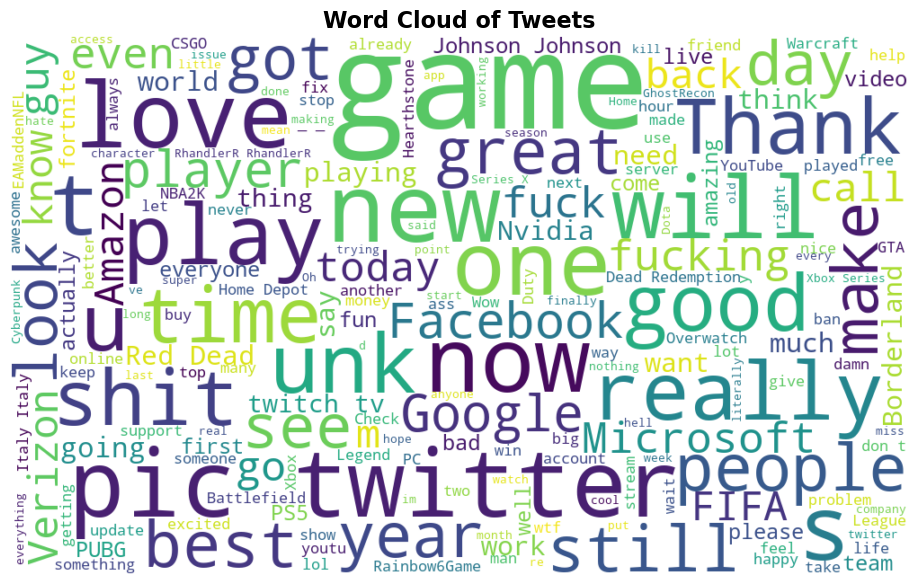

In [31]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Combine all tweets into a single string
all_words = ' '.join([str(tweet) for tweet in train_df['Tweet_Content']])

# Define stopwords (common words to ignore)
stopwords = set(STOPWORDS)
stopwords.update(["https", "co", "RT", "amp"])  # add more if needed

# Generate the word cloud
wordcloud = WordCloud(
    width=1000, height=600,
    background_color='white',
    stopwords=stopwords,
    colormap='viridis',
    max_words=200,
    max_font_size=150,
    random_state=42
).generate(all_words)

# Display the word cloud
plt.figure(figsize=(12, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweets', fontsize=16, weight='bold')
plt.show()



C:\Users\chait\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


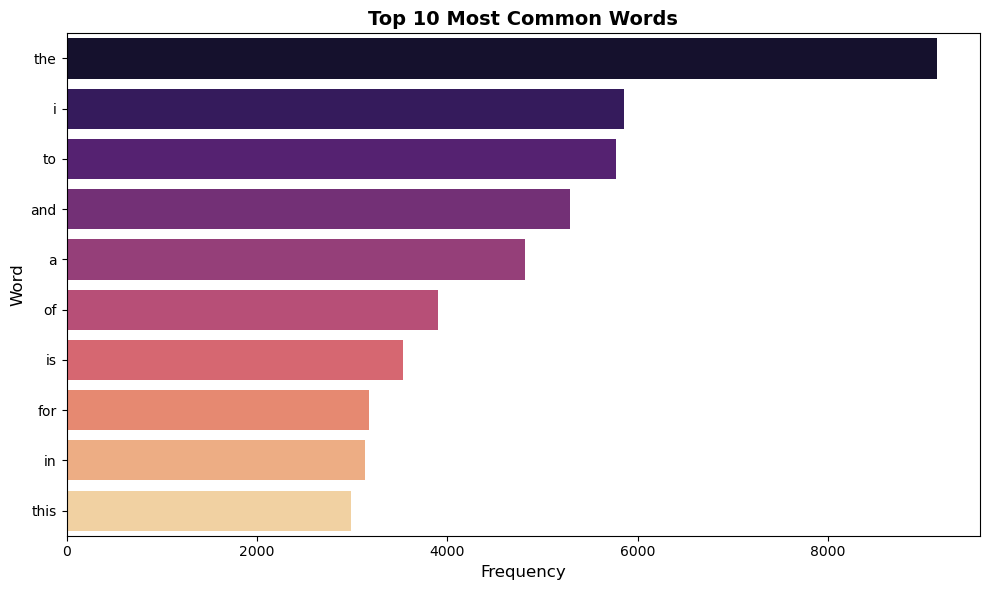

In [33]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Combine all tweets into one large text
all_text = ' '.join([str(tweet) for tweet in train_df['Tweet_Content']])

# Clean text: remove URLs, mentions, special characters, and numbers
clean_text = re.sub(r'http\S+|www\S+|@\S+|[^A-Za-z\s]', '', all_text.lower())

# Split into words
words = clean_text.split()

# Count word frequencies
word_counts = Counter(words)

# Get the top 10 most common words
common_words = word_counts.most_common(10)

# Convert to separate lists for plotting
words, counts = zip(*common_words)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=list(counts), y=list(words), palette='magma')
plt.title("Top 10 Most Common Words", fontsize=14, weight='bold')
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("Word", fontsize=12)
plt.tight_layout()
plt.show()


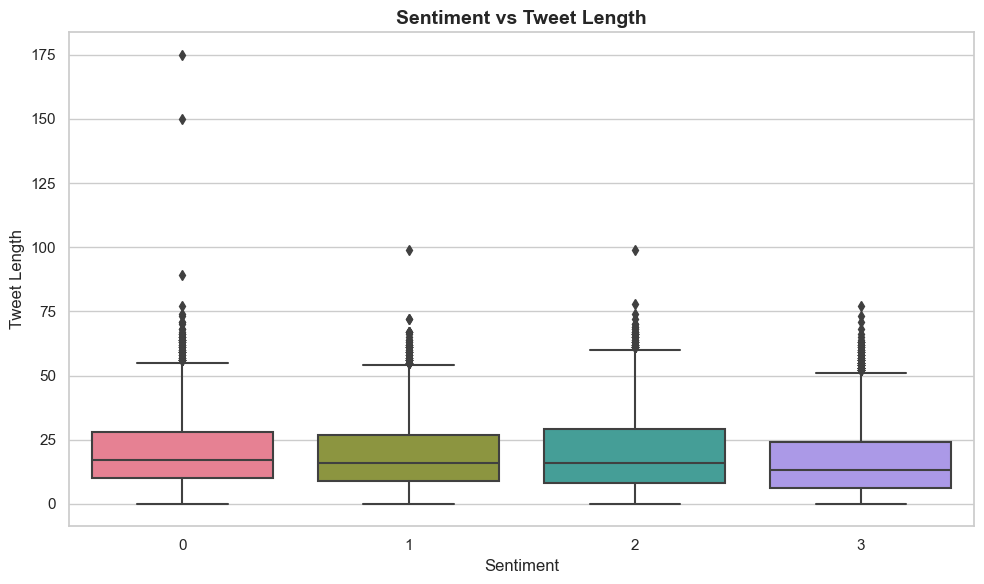

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a new column for tweet length (number of words)
train_df['tweet_length'] = train_df['Tweet_Content'].apply(lambda x: len(str(x).split()))

# Set the plotting style
sns.set(style="whitegrid", palette="pastel")

# Create the boxplot
plt.figure(figsize=(10,6))
sns.boxplot(x='Sentiment', y='tweet_length', data=train_df, palette='husl')

# Add title and labels
plt.title("Sentiment vs Tweet Length", fontsize=14, weight='bold')
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Tweet Length", fontsize=12)

plt.tight_layout()
plt.show()


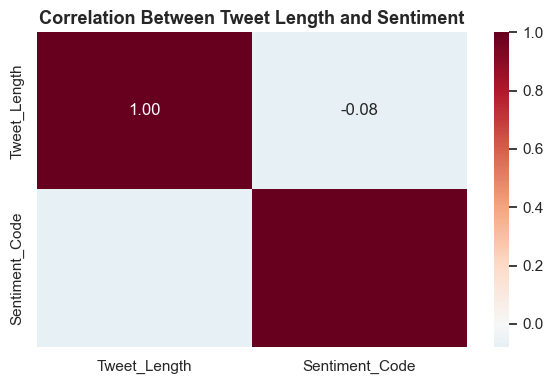

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert sentiment to numeric codes
train_df['Sentiment_Code'] = train_df['Sentiment'].astype('category').cat.codes

# Create a new column for tweet length
train_df['Tweet_Length'] = train_df['Tweet_Content'].apply(lambda x: len(str(x).split()))

# Select only numeric columns for correlation
corr = train_df[['Tweet_Length', 'Sentiment_Code']].corr()

# Plot heatmap
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='RdBu_r', center=0, fmt=".2f")

# Add title
plt.title("Correlation Between Tweet Length and Sentiment", fontsize=13, weight='bold')

plt.tight_layout()
plt.show()
